In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from tqdm import tqdm
import tensorflow as tf
import tensorflow_datasets as tfds
import re
from collections import Counter

In [9]:
# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [10]:
# Load IMDb dataset from TensorFlow Datasets
(ds_train, ds_test), ds_info = tfds.load(
    'imdb_reviews',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True,
)

In [11]:
# Function to preprocess text - FIXED
def preprocess_text(text, label):
    # text is already bytes from tfds.as_numpy
    text = text.decode('utf-8')
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text, label

In [12]:
# Preprocess the data
train_texts = []
train_labels = []
test_texts = []
test_labels = []

for text, label in tfds.as_numpy(ds_train):
    processed_text, processed_label = preprocess_text(text, label)
    train_texts.append(processed_text)
    train_labels.append(processed_label)

for text, label in tfds.as_numpy(ds_test):
    processed_text, processed_label = preprocess_text(text, label)
    test_texts.append(processed_text)
    test_labels.append(processed_label)

In [13]:
# Build vocabulary (word to index mapping)
def build_vocab(texts, max_vocab_size=10000):
    word_counts = Counter()
    for text in texts:
        words = text.split()
        word_counts.update(words)

    # Add special tokens
    vocab = {'<pad>': 0, '<unk>': 1}

    # Add most common words
    for word, count in word_counts.most_common(max_vocab_size - 2):
        vocab[word] = len(vocab)

    return vocab

vocab = build_vocab(train_texts)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 10000


In [14]:
# Convert texts to sequences of indices
def text_to_sequence(text, vocab, max_length=200):
    words = text.split()
    sequence = [vocab.get(word, vocab['<unk>']) for word in words[:max_length]]
    if len(sequence) < max_length:
        sequence += [vocab['<pad>']] * (max_length - len(sequence))
    return sequence

In [15]:
# Convert all texts to sequences
train_sequences = [text_to_sequence(text, vocab) for text in train_texts]
test_sequences = [text_to_sequence(text, vocab) for text in test_texts]

In [16]:
# Convert to PyTorch tensors
X_train = torch.tensor(train_sequences, dtype=torch.long)
y_train = torch.tensor(train_labels, dtype=torch.float)
X_test = torch.tensor(test_sequences, dtype=torch.long)
y_test = torch.tensor(test_labels, dtype=torch.float)

In [17]:
# Create PyTorch Dataset
class IMDbDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.labels[idx]

In [19]:
# Split training data into train and validation sets
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

In [20]:
# Create datasets
train_dataset = IMDbDataset(X_train_split, y_train_split)
val_dataset = IMDbDataset(X_val, y_val)
test_dataset = IMDbDataset(X_test, y_test)

In [21]:
# Define the Deep RNN model
class DeepRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout_rate=0.5):
        super(DeepRNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.rnn = nn.GRU(
            embed_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_rate if num_layers > 1 else 0,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: (batch_size, sequence_length)
        embedded = self.embedding(x)
        # embedded shape: (batch_size, sequence_length, embed_dim)

        output, hidden = self.rnn(embedded)
        # output shape: (batch_size, sequence_length, hidden_dim * 2)

        # Use the last time step output from both directions
        hidden_cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # hidden_cat shape: (batch_size, hidden_dim * 2)

        out = self.dropout(hidden_cat)
        out = self.fc(out)
        out = self.sigmoid(out)
        return out.squeeze()

In [22]:
# Function to train and evaluate model
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            sequences, labels = sequences.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for sequences, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation"):
                sequences, labels = sequences.to(device), labels.to(device)

                outputs = model(sequences)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                predicted = (outputs > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

In [23]:
# Function to evaluate model with all metrics
def evaluate_model(model, test_loader):
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(test_loader, desc="Evaluating"):
            sequences, labels = sequences.to(device), labels.to(device)

            outputs = model(sequences)
            probabilities = outputs.cpu().numpy()
            predictions = (outputs > 0.5).float().cpu().numpy()

            all_predictions.extend(predictions)
            all_probabilities.extend(probabilities)
            all_labels.extend(labels.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_probabilities = np.array(all_probabilities)
    all_labels = np.array(all_labels)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    precision = precision_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)
    auc = roc_auc_score(all_labels, all_probabilities)

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probabilities)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc': auc,
        'confusion_matrix': cm,
        'roc': (fpr, tpr)
    }

    return metrics

In [24]:
# Function to visualize metrics
def visualize_metrics(train_losses, val_losses, train_accuracies, val_accuracies, metrics):
    plt.figure(figsize=(15, 10))

    # Plot training and validation loss
    plt.subplot(2, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 2, 2)
    plt.plot(train_accuracies, label='Training Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Accuracy vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot confusion matrix
    plt.subplot(2, 2, 3)
    cm = metrics['confusion_matrix']
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    # Add text annotations to the confusion matrix
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Plot ROC curve
    plt.subplot(2, 2, 4)
    fpr, tpr = metrics['roc']
    plt.plot(fpr, tpr, label=f'AUC = {metrics["auc"]:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Print metrics
    print("\nEvaluation Metrics:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")

In [25]:
# Hyperparameter tuning function
def hyperparameter_tuning(param_grid, X_train, y_train, X_val, y_val, vocab_size, max_epochs=3):
    train_dataset = IMDbDataset(X_train, y_train)
    val_dataset = IMDbDataset(X_val, y_val)

    results = []

    for embed_dim in param_grid['embed_dim']:
        for hidden_dim in param_grid['hidden_dim']:
            for num_layers in param_grid['num_layers']:
                for dropout_rate in param_grid['dropout_rate']:
                    for learning_rate in param_grid['learning_rate']:
                        for batch_size in param_grid['batch_size']:
                            print(f"\nTesting params: embed_dim={embed_dim}, hidden_dim={hidden_dim}, "
                                  f"num_layers={num_layers}, dropout={dropout_rate}, "
                                  f"lr={learning_rate}, batch_size={batch_size}")

                            # Create data loaders
                            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                            val_loader = DataLoader(val_dataset, batch_size=batch_size)

                            # Initialize model with current params
                            model = DeepRNN(vocab_size, embed_dim, hidden_dim, num_layers, dropout_rate).to(device)
                            criterion = nn.BCELoss()
                            optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                            # Train for specified epochs
                            train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(
                                model, train_loader, val_loader, criterion, optimizer, epochs=max_epochs
                            )

                            # Store results
                            results.append({
                                'embed_dim': embed_dim,
                                'hidden_dim': hidden_dim,
                                'num_layers': num_layers,
                                'dropout_rate': dropout_rate,
                                'learning_rate': learning_rate,
                                'batch_size': batch_size,
                                'val_accuracy': val_accuracies[-1],
                                'val_loss': val_losses[-1]
                            })

    # Sort results by validation accuracy
    results.sort(key=lambda x: x['val_accuracy'], reverse=True)
    return results

In [26]:
# Hyperparameter tuning
param_grid = {
    'embed_dim': [64, 128],
    'hidden_dim': [64, 128],
    'num_layers': [1, 2],
    'dropout_rate': [0.3, 0.5],
    'learning_rate': [0.001, 0.0005],
    'batch_size': [32, 64]
}

In [ ]:
# Run hyperparameter tuning
tuning_results = hyperparameter_tuning(
    param_grid, X_train_split, y_train_split, X_val, y_val, vocab_size, max_epochs=2
)

In [28]:
# Print the best hyperparameters
print("\nBest Hyperparameters:")
for key, value in tuning_results[0].items():
    print(f"{key}: {value}")


Best Hyperparameters:
embed_dim: 128
hidden_dim: 128
num_layers: 2
dropout_rate: 0.3
learning_rate: 0.001
batch_size: 32
val_accuracy: 0.8508
val_loss: 0.33138644478366347


In [29]:
# Initialize model with best hyperparameters
best_params = tuning_results[0]
best_model = DeepRNN(
    vocab_size,
    best_params['embed_dim'],
    best_params['hidden_dim'],
    best_params['num_layers'],
    best_params['dropout_rate']
).to(device)

In [30]:
# Train with best hyperparameters
best_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
best_val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])
best_test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

best_criterion = nn.BCELoss()
best_optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])

In [34]:
# Train the best model
best_train_losses, best_val_losses, best_train_accuracies, best_val_accuracies = train_and_evaluate(
    best_model, best_train_loader, best_val_loader, best_criterion, best_optimizer, epochs=5
)

Epoch 1/5 - Validation: 100%|██████████| 79/79 [00:00<00:00, 285.17it/s]


Epoch 1/5 - Train Loss: 0.0039, Train Acc: 0.9985, Val Loss: 1.0829, Val Acc: 0.8672


Epoch 2/5 - Validation: 100%|██████████| 79/79 [00:00<00:00, 282.36it/s]


Epoch 2/5 - Train Loss: 0.0047, Train Acc: 0.9984, Val Loss: 0.9947, Val Acc: 0.8620


Epoch 3/5 - Validation: 100%|██████████| 79/79 [00:00<00:00, 280.41it/s]


Epoch 3/5 - Train Loss: 0.0064, Train Acc: 0.9977, Val Loss: 1.2233, Val Acc: 0.8632


Epoch 4/5 - Validation: 100%|██████████| 79/79 [00:00<00:00, 248.83it/s]


Epoch 4/5 - Train Loss: 0.0071, Train Acc: 0.9977, Val Loss: 1.0179, Val Acc: 0.8708


Epoch 5/5 - Validation: 100%|██████████| 79/79 [00:00<00:00, 280.41it/s]

Epoch 5/5 - Train Loss: 0.0035, Train Acc: 0.9988, Val Loss: 1.3326, Val Acc: 0.8644


In [35]:
# Evaluate the best model
best_test_metrics = evaluate_model(best_model, best_test_loader)

Evaluating: 100%|██████████| 782/782 [00:03<00:00, 253.13it/s]


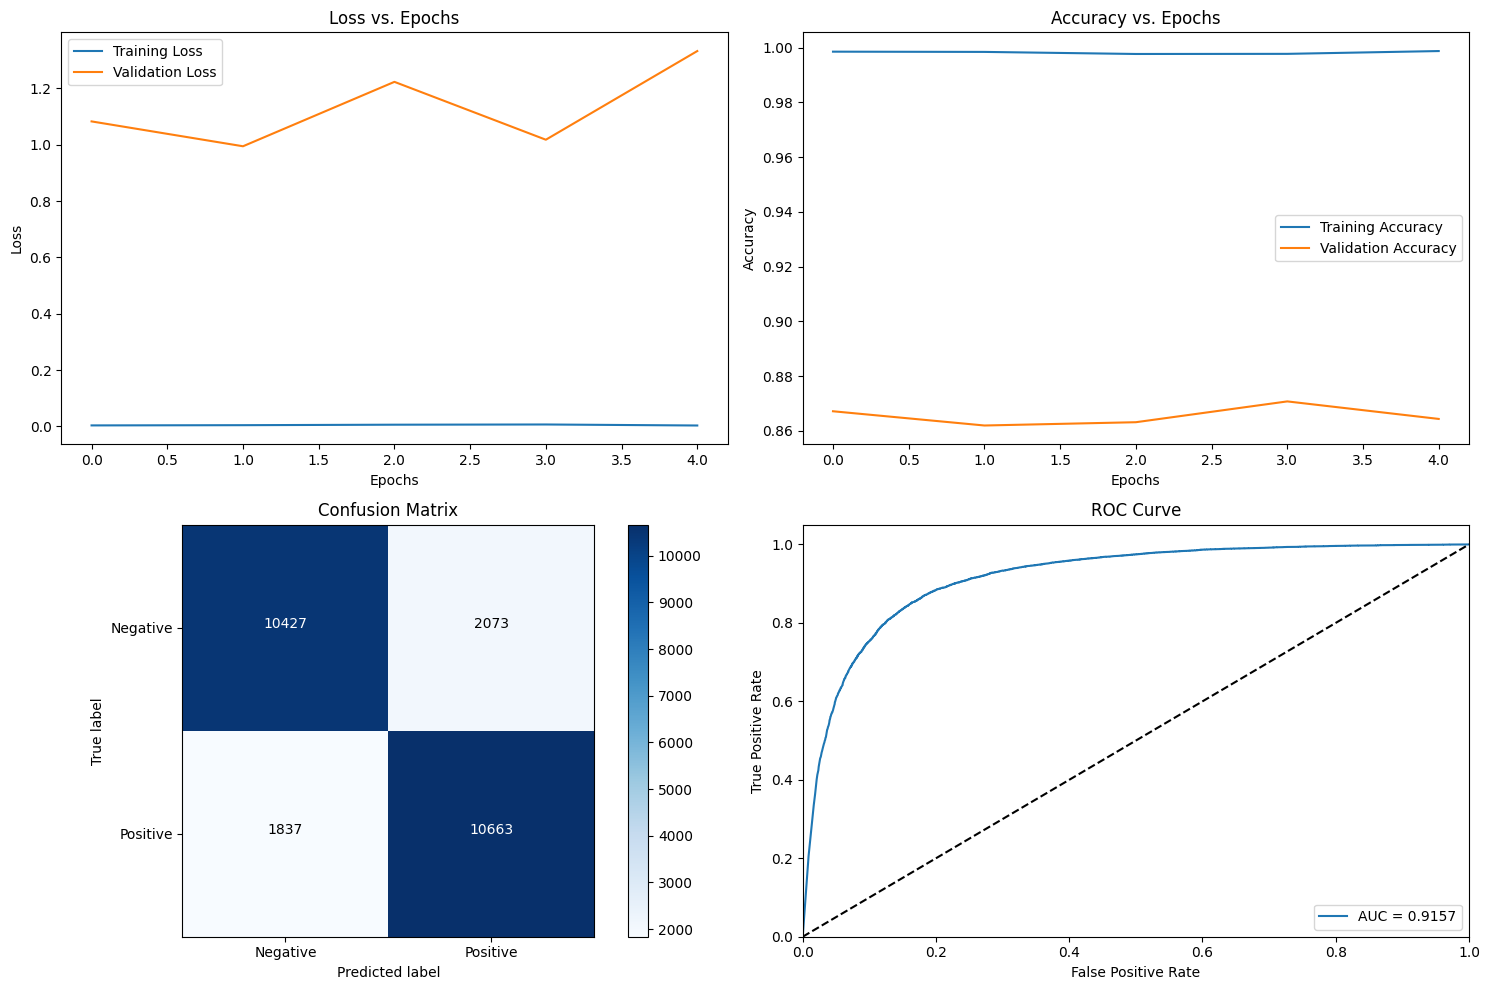


Evaluation Metrics:
Accuracy: 0.8436
Precision: 0.8372
Recall: 0.8530
F1 Score: 0.8451
AUC: 0.9157


In [36]:
# Visualize results for the best model
visualize_metrics(
    best_train_losses, best_val_losses, best_train_accuracies, best_val_accuracies, best_test_metrics
)